# Initial Investigations

looking thru: https://www.midi.org/forum/279-yamaha-bull-dump-data-format,
http://rnhart.net/articles/bulk-dump.htm

In [1]:
from __future__ import print_function
import itertools

In [2]:
def hexbyte(x):
    return "{:02X}".format(x)

def binbyte(x):
    return "{:08b}".format(x)

def tohex(by):
    return " ".join(hexbyte(x) for x in by)
def tobin(by):
    return " ".join(binbyte(x) for x in by)

def hexline(by):
    if len(by) <= 24:
        return tohex(by)
    else:
        return tohex(by[:20]) + "..." + tohex(by[-4:])

def takebyn(by, n=8):
    for i in range(0, len(by), n):
        yield by[i:i+n]

def printhex(by, n=8, startpad=0):
    for x in takebyn(by, n):
        print(tohex(x))



In [3]:
with open('data/syxout.txt') as hexdata:
    lines = [bytearray.fromhex(line.strip()) for line in hexdata]

## Picking at the message structure

In [4]:
for line in lines:
    print(hexline(line))

F0 43 73 7F 44 06 0A 10 00 10 00 00 00 00 1F 00 0A 03 68 03...37 00 3B F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 10 00 00 37 00 03 45 7F...3B 10 0A F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 20 00 55 27 37 42 00 33...41 00 28 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 30 00 20 00 32 00 00 00...4B 00 56 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 40 00 00 05 48 4F 01 24...41 00 67 F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 50 00 20 00 33 00 00 00...0B 00 6C F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 60 00 3B 21 01 43 00 01...24 00 4D F7
F0 43 73 7F 44 06 0A 10 00 10 00 00 70 00 29 2F 2F 51 44 01...00 00 1C F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 00 00 00 46 43 02 4A 42...40 22 21 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 10 00 00 02 12 1D 42 29...43 00 54 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 20 00 45 02 3E 00 00 37...4F 00 6D F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 30 00 00 06 48 56 00 4C...03 08 27 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 40 00 10 58 00 02 60 02...01 08 37 F7
F0 43 73 7F 44 06 0A 10 00 10 00 01 50

In [5]:
lb = lines[0]
ls = lines[-4]

### Header
sysex-flag/manufacturer/device/data type header: `F0 43 73 7F 44 06`. 

If this is using the same conventions as the PSR-225, then `0A` is for song data and `09` is for the one-touch panel bank

In [6]:
tohex(lb[:7])

'F0 43 73 7F 44 06 0A'

### 'SS' Size bytes. 

There appear to be four of them. At the EOS this is '00 01 00 01'
the longest messages have this as '10 00 10 00', the last message before EOS has this as '08 68 08 68'.


It appears to be two repeated
 (at least, in the case of the 0A. The 09 data, with only one message, appears to be different again.)

In [7]:
tohex(lb[7:11])

'10 00 10 00'

### three 'ZZ' running total bytes. 

At the EOS this is '7F 7F 7F', then immediately followed by the end F7.


In [8]:
tohex(lb[11:14])

'00 00 00'

### the 'KK' checksum and end-of-message flag F7.

In [9]:
tohex(lb[-2:])


'3B F7'

This should, and I say *should*, be of a similar format, so...
If this works, sum of SS SS SS to KK inclusive should be 0 (mod 128).

In [10]:
print([sum(line[7:-1]) % 128 for line in lines])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 0, 127]


It worked, except for the two end-of-section messages, which don't have the checksum byte.

### Checking the Numbers

In [11]:
def unpackseven(by):
    # Ignore the first bit, which is always zero.
    # The most signifcant bit comes first
    sum = 0
    for v, b in zip(by, range(len(by)-1, -1, -1)):
        sum += v << (b*7)
    return sum

In [12]:
"%#x"%(unpackseven(bytearray.fromhex('10 00')))

'0x800'

In [13]:
len(lb[14:-2])

2048

0x800, or 2048 bytes of encoded data seems to be the maximum.
the ZZ bytes appear to increment by this amount.

that penultimate message should be 0x468, or 1128, bytes...

In [14]:
"%X"%(unpackseven(bytearray.fromhex('08 68')))

'468'

In [15]:
unpackseven(ls[9:11]) == len(ls[14:-2])

True

In [16]:
len(ls[14:-2])

1128

Yep.

## What's all that data?
Instead encoding one byte to two by nybble, with 0F 07 == 7F like in the [PSR-225](http://rnhart.net/articles/bulk-dump.htm), it seems that the 'payload' data uses all seven available bits, which could mean several things.

In [17]:
payloads = [line[14:-2] for line in lines[:-3]]

In [18]:
payload = bytearray().join(payloads)

From staring at the 'payload' in a hex editor, I have recognised some patterns. I think that every 8th byte is some sort of 'parity' byte or something. Ignoring these bytes you can see the ascii for 'YAMAHA' and 'MTrk' and 'PresetStyle\x00'. So that's a start.

In [19]:
len(payload)/8

9613

### What Is That Eighth Byte?

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
pays = np.array(payload).reshape((9613,8))

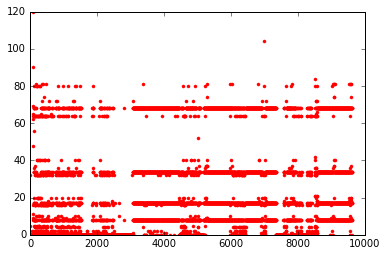

In [22]:
plt.plot(pays[:,7], 'r.')

In [23]:
np.asarray(np.unique(pays[:,7], return_counts=True)).T

array([[   0, 3084],
       [   1,  120],
       [   2,  122],
       [   4,   96],
       [   5,   28],
       [   8, 1468],
       [   9,   18],
       [  10,   25],
       [  11,    1],
       [  16,   93],
       [  17, 1348],
       [  18,   19],
       [  20,   40],
       [  21,    4],
       [  32,  126],
       [  33,    1],
       [  34, 1354],
       [  36,   17],
       [  37,   12],
       [  40,   34],
       [  42,    1],
       [  48,    1],
       [  52,    1],
       [  56,    1],
       [  62,    1],
       [  64,  126],
       [  65,    4],
       [  66,    1],
       [  68, 1398],
       [  69,    1],
       [  72,   16],
       [  74,    5],
       [  80,   25],
       [  81,   18],
       [  84,    1],
       [  90,    1],
       [ 104,    1],
       [ 120,    1]])

In [24]:
tobin(pays[pays[:,7]==65,:][2])

'01110000 00000101 01111110 01111111 00001001 00000001 01110111 01000001'

In [25]:
tobin(np.unique(pays[:,7]))

'00000000 00000001 00000010 00000100 00000101 00001000 00001001 00001010 00001011 00010000 00010001 00010010 00010100 00010101 00100000 00100001 00100010 00100100 00100101 00101000 00101010 00110000 00110100 00111000 00111110 01000000 01000001 01000010 01000100 01000101 01001000 01001010 01010000 01010001 01010100 01011010 01101000 01111000'

... I dunno. Maybe we should just ignore all the 8th bytes.

In [26]:
payload7 = bytearray()
for i in range(0, len(payload), 8):
    payload7.extend(payload[i:i+7])

### The Solution

If I had to squeeze 8 bits down into seven, how would I do it?
Maybe, we take each of the seven bits of the eighth byte and stick them in front of the previous seven?

In [27]:
def reconstitute(by):
    blob = by[:7]
    for i in range(7):
        bitmask = 0b01000000 >> i
        blob[i] = blob[i] | ((by[7] & bitmask) << i+1)
    return blob

In [28]:
payload8 = bytearray().join(reconstitute(g) for g in takebyn(payload, 8))

In [29]:
import re

Note that whenever an F0 occurs it is always followed by F7:

In [30]:
map(tohex, re.findall('\xF0[\x00-\x7F]*[\x80-\xFF]', payload8))

['F0 09 43 10 4C 02 01 00 01 11 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 11 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 12 4C 02 01 00 01 10 F7',
 'F0 09 43 12 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 10 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 12 4C 02 01 00 01 10 F7',
 'F0 09 43 12 4C 02 01 20 42 11 F7',
 'F0 09 43 10 4C 02 01 00 01 10 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 10 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 10 4C 02 01 00 01 10 F7',
 'F0 09 43 10 4C 02 01 20 42 11 F7',
 'F0 09 43 11 4C 02 01 00 01 10 F7',
 'F0 09 43 11 4C 02 01 20 42 11 F7',
 'F0 09 43 13 4C 02 01 00 01 10 F7',
 'F0 09 43 13 4C 02 01 20 42 11 F7',
 'F0 09 43 11 4C 02 01 00 01 11 F7',
 'F0 09 43 11 4C 02 01 20 42 11 F7',
 'F0 05 7E 7F 09 01 F7',
 'F0 09 43 15 4C 02 01 00 01 11 F7',
 'F0 09 43 15 4C 02 01 20 42 11 F7',
 'F0 09 43 1

It sure looks like there are some system exclusive messages in here! (Stored in MIDI file format, of course.)

Leafing through the manual (pg 110-111), it seems these are the GM System / volume / tuning / reverb / chorus events

And here are some style meta-events:

In [31]:
map(tohex, re.findall('\x43\x76\x1A\x04.{2}', payload8))

['43 76 1A 04 00 5B',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 87',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00',
 '43 76 1A 04 00 00']

# Figuring Out The File Structure

Assuming the file structure is similar to the [PSR-225's block system](http://rnhart.net/articles/bulk-dump.htm)...

In [32]:
len(payload8)

67291

It looks like there are 67291 bytes of decoded data instead of the 66766 bytes in the PSR-225.

In [33]:
printhex(payload8[:0x15a], 32)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F 00 0A 00 0F 00 13 00
16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 05 00
08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00 17 00 17 00 18 00 18 00 19 00 1A 00 1A 00 1B 00
1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 19 00 19 00 19 00 19 00 19 00 18 00 18 00 18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00
14 00 13 00 13 00 12 00 12 00 11 00 11 00 10 00 10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A 00 19 00
19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 0

I have no idea what the first 0x15A bytes are. Maybe it's a bunch of 16-bit numbers?

In [34]:
printhex(payload8[0x15a:0x162])

64 02 BC 21 07 1F 05 0F


The DGX-505 has 5 UserSongs compared to the PSR-225's three. Each user song has five normal tracks and one chord/accompaniment track (track A).

At the time this dump was gathered, all five songs had data, and used the following tracks as displayed on the panel:
1. `1 _ _ _ _ A`
2. `1 2 3 _ _ _`
3. `1 2 3 4 5 _`
4. `1 _ 3 _ _ _`
5. `1 2 3 4 _ _`

In [35]:
track_bitfields = payload8[0x15d:0x162]

for b in track_bitfields:
    print(binbyte(b))

00100001
00000111
00011111
00000101
00001111


The five bytes from 0x15d to 0x161 appear to correspond to the five usersongs, with the low 5 bits of each representing the active tracks on each (from least to most significant bit, track 1 - 2 - 3 - 4 - 5 - A).

This corresponds to offsets 0x00001-0x00003 on the PSR-225.

Still don't know what `64 02 BC` is, though.

In [36]:
printhex(payload8[0x162:0x1f3], 32)

00 00 00 00 00 00 00 00 27 00 00 00 0B 00 00 00 25 00 00 00 08 00 00 00 11 00 00 00 27 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 25 00 00 00 0B 00 00 00 0B 00 00 00 0B 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 12 00 00 00 1F 00 00 00 21 00 00 00 25 00 00 00 25 00 00 00
00 00 00 00 08 00 00 00 00 00 00 00 08 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 11 00 00 00
10 00 00 00 10 00 00 00 11 00 00 00 00 00 00 00 00


Following are some bytes of more unknown stuff which could be 32 bit integers?

In [37]:
printhex(payload8[0x1f3:0x22f], 12)
payload8[0x1f3:0x22f].decode('ascii')

50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00
50 72 65 73 65 74 53 74 79 6C 65 00


u'PresetStyle\x00PresetStyle\x00PresetStyle\x00PresetStyle\x00PresetStyle\x00'

... followed by five repeats of ascii 'PresetStyle' and `00`. The PSR-225 only has three of these (starting from 0x00007), so this has probably got something to do with each song.

In [38]:
beginning_blocks = payload8[0x22f:0x24d]

printhex(beginning_blocks, 6)

01 FF FF FF FF 02
19 12 14 FF FF 13
43 47 7B 82 51 44
0B FF 07 FF FF 08
0D 0F 0A 11 FF 0C


Immediately following that, we have what appears to be the 30 bytes from 0x22f through 0x24c indicating the beginning blocks, corresponding to 0x0002B-0x0003F on the PSR-225.

Each group of six bytes corresponds to a usersong in order, and each byte corresponds to a track, from 1-5, followed by the *time track* with the tempo, SysEx, etc. (Compare with the PSR-225, which has 6+1 tracks for each of its 3 songs and therefore needs 21 (=0x15) bytes total.)

Blocks are numbered 0x01 to 0x82 and `FF` indicates that the track is not in use.

In [39]:
next_blocks = payload8[0x24d:0x2cf]

printhex(next_blocks, 16)

04 03 FF 05 06 FF 09 FF FF FF FF FF 0E FF 10 FF
FF 17 FF 15 16 1B 18 FF 1A FF FF 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 45 FF 46 FF 48 49 4A 4B 60 4D 4E 4F 50 58
52 53 54 55 56 57 FF 59 5A 5B 5C 5D FF 00 00 61
62 63 7A 00 00 00 00 00 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 FF 7C 7D 7E 7F 80 81
FF 4C


Running from 0x24d to 0x2ce is the table of 0x82 (=130) next blocks, corresponding to 0x00040-0x000C1 on the PSR-225.

`00` indicates unused blocks, `FF` indicates final blocks.

In [40]:
printhex(payload8[0x2cf:0x2d5])
payload8[0x2cf:0x2d5].decode('ascii')

50 4B 30 30 30 31


u'PK0001'

At 0x2cf, we find 'PK0001', which corresponds to the PSR-225's 'PK9801' at 0x000C2, and marks the beginning of the block data at 0x2d5.

In [41]:
printhex(payload8[0x106d5:])
payload8[0x106d5:].decode('ascii')

50 4B 30 30 30 31


u'PK0001'

The final six bytes, spelling 'PK0001' again from 0x106d5 to 0x106da, mark the end of the block data and correspond to 0x104C8-0x104CD on the PSR-225.

In [42]:
(0x106d5-0x2d5)/0x82

512

Like the PSR-225, the blocks are 0x200 = 512 bytes in size.

Block 0x01 begins at offset 0x2d5:

In [43]:
printhex(payload8[0x2d5:0x2d5+8])
payload8[0x2d5:0x2d5+8]

4D 54 72 6B 00 00 07 C2


bytearray(b'MTrk\x00\x00\x07\xc2')

And we can see the start of an MTrk chunk.

To calculate the start each block we can use a simple formula
```
offset(n) = 0x2d5 + (0x200 * (n-1))
```
or, to simplify, 
```
offset(n) = 0xd5 + (0x200 * n)
```


In [44]:
def chunk_offset(n):
    if 0x01 <= n <= 0x82:
        return 0xd5 + (0x200*n)
    else:
        raise ValueError("Invalid chunk", n)

In [45]:
track_blocks = [x for x in beginning_blocks if x != 0xFF]

for n in track_blocks:
    offset = chunk_offset(n)
    bits = payload8[offset:offset+4]
    print(u"Block 0x{:02x} at 0x{:05x}: {} - {}".format(n, offset, tohex(bits), bits.decode('ascii')))


Block 0x01 at 0x002d5: 4D 54 72 6B - MTrk
Block 0x02 at 0x004d5: 4D 54 72 6B - MTrk
Block 0x19 at 0x032d5: 4D 54 72 6B - MTrk
Block 0x12 at 0x024d5: 4D 54 72 6B - MTrk
Block 0x14 at 0x028d5: 4D 54 72 6B - MTrk
Block 0x13 at 0x026d5: 4D 54 72 6B - MTrk
Block 0x43 at 0x086d5: 4D 54 72 6B - MTrk
Block 0x47 at 0x08ed5: 4D 54 72 6B - MTrk
Block 0x7b at 0x0f6d5: 4D 54 72 6B - MTrk
Block 0x82 at 0x104d5: 4D 54 72 6B - MTrk
Block 0x51 at 0x0a2d5: 4D 54 72 6B - MTrk
Block 0x44 at 0x088d5: 4D 54 72 6B - MTrk
Block 0x0b at 0x016d5: 4D 54 72 6B - MTrk
Block 0x07 at 0x00ed5: 4D 54 72 6B - MTrk
Block 0x08 at 0x010d5: 4D 54 72 6B - MTrk
Block 0x0d at 0x01ad5: 4D 54 72 6B - MTrk
Block 0x0f at 0x01ed5: 4D 54 72 6B - MTrk
Block 0x0a at 0x014d5: 4D 54 72 6B - MTrk
Block 0x11 at 0x022d5: 4D 54 72 6B - MTrk
Block 0x0c at 0x018d5: 4D 54 72 6B - MTrk


We can see that the blocks marked as the beginning blocks for each track do, indeed, contain the start of the tracks.

### The Remainder
There are two regions left unexplained:

In [46]:
printhex(payload8[:0x15d], 32)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F 00 0A 00 0F 00 13 00
16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 05 00
08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00 17 00 17 00 18 00 18 00 19 00 1A 00 1A 00 1B 00
1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00
1E 00 19 00 19 00 19 00 19 00 19 00 18 00 18 00 18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00
14 00 13 00 13 00 12 00 12 00 11 00 11 00 10 00 10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A 00 19 00
19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00
0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 0

In [47]:
printhex(payload8[0x162:0x1f3], 32)

00 00 00 00 00 00 00 00 27 00 00 00 0B 00 00 00 25 00 00 00 08 00 00 00 11 00 00 00 27 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 25 00 00 00 0B 00 00 00 0B 00 00 00 0B 00 00 00
00 00 00 00 00 00 00 00 00 00 00 00 12 00 00 00 1F 00 00 00 21 00 00 00 25 00 00 00 25 00 00 00
00 00 00 00 08 00 00 00 00 00 00 00 08 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 11 00 00 00
10 00 00 00 10 00 00 00 11 00 00 00 00 00 00 00 00


We've accounted for pretty much everything found in the PSR-225's song dump format, except for the very first byte, offset 0x00000, which is supposed to be a bitfield for the songs in use. If the same pattern is used for the DGX-505, then we should expect to see a `00011111` or `1F` byte somewhere, as all five songs were in use.
The very first byte, offset 0x0, is, in fact, `1F`, so that might just be it (I'll have to delete one of the songs to check).

There's also one feature 'Step Recording' (offset 0x0004-0x0006 on PSR-225) the DGX-505 doesn't have. If the (abscence of) step-recorded tracks was noted directly after the normal tracks, this would account for five `00` bytes directly after the normal tracks at 0x162, and the rest lines up rather nicely as a bunch of 32 bit numbers


In [48]:
printhex(payload8[0x167:0x1f3], 32)

00 00 00 27 00 00 00 0B 00 00 00 25 00 00 00 08 00 00 00 11 00 00 00 27 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 00 00 00 00 25 00 00 00 0B 00 00 00 0B 00 00 00 0B 00 00 00 00 00 00 00 00
00 00 00 00 00 00 00 12 00 00 00 1F 00 00 00 21 00 00 00 25 00 00 00 25 00 00 00 00 00 00 00 08
00 00 00 00 00 00 00 08 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 11 00 00 00 10 00 00 00 10
00 00 00 11 00 00 00 00 00 00 00 00


Let's describe some patterns.

From offset 0x0 to 0x18, there's a bunch of bytes. 0x0 may be the song-usage-bitfield thing.

In [49]:
printhex(payload8[:0x19], 32)

1F 00 0A 03 E8 03 E8 01 F4 22 28 1E 1E 05 7F 1E 00 00 19 00 01 00 00 01 7F


From 0x19 to 0x2c, we get small numbers that increase by five, three, two, two, one, one, one, one...

In [50]:
printhex(payload8[0x19:0x2d], 32)

00 0A 00 0F 00 13 00 16 00 18 00 1A 00 1B 00 1C 00 1D 00 1E


Then, after 0x2b, the numbers stop increasing.

In [51]:
printhex(payload8[0x2b:0x7d], 32)

00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E


...until 0x7d, where it drops back down to `05` and starts increasing again, starting in steps of three and then slowing down again until also stopping at `1E`...

In [52]:
printhex(payload8[0x7d:0xe1], 32)

00 05 00 08 00 0B 00 0D 00 0F 00 11 00 13 00 15 00 16 00 17 00 17 00 18 00 18 00 19 00 1A 00 1A
00 1B 00 1B 00 1B 00 1C 00 1C 00 1C 00 1D 00 1D 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E 00 1E
00 1E 00 1E


and then at 0xe1 it drops to `19` and starts going down, speeding up...

In [53]:
printhex(payload8[0xe1:0x11d], 32)

00 19 00 19 00 19 00 19 00 19 00 18 00 18 00 18 00 17 00 17 00 16 00 16 00 15 00 15 00 14 00 14
00 13 00 13 00 12 00 12 00 11 00 11 00 10 00 10 00 0F 00 0E 00 0D 00 0C 00 0B 00 0A


And then jumping back up to `19` at 0x11d, and then two steps of five and then a whole bunch of `0F`

In [54]:
printhex(payload8[0x11d:0x159], 32)

00 19 00 19 00 14 00 14 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F
00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F 00 0F


And then four more bytes of whatever. I'm baffled, really.

In [55]:
printhex(payload8[0x159:0x15d], 32)

00 64 02 BC


In [57]:
mystery_region = payload8[0x019:0x159]

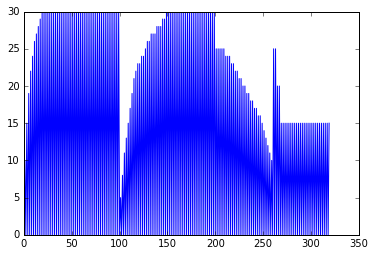

In [62]:
plt.plot(mystery_region)

Is rather pretty, though.

In [78]:
mystery_numbers = [(x<<4)+y for x,y in takebyn(payload8[1:0x15d], 2)]

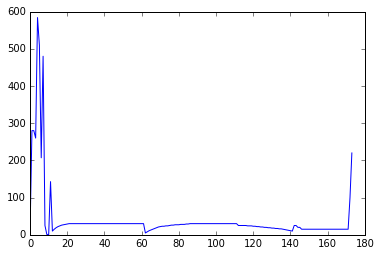

In [81]:
plt.plot(mystery_numbers)